###### Import libraries

In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy as cp
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
# from mpl_toolkits.basemap import Basemap


###### Chirps

In [4]:
chirps=xr.open_dataset("CHIRPS/Chirps_West_Africa.nc")
chirps_data = chirps.sel(latitude = slice(4,12), longitude = slice(-3,1.5), time = slice('1983','2017')).precip
chirps_data = chirps_data.resample(time = 'y').sum('time')



###### Cru

In [5]:

cru = xr.open_dataset("CRU/cru_ts4.05.1901.2020.pre.dat.nc").pre
cru_data = cru.sel(lat = slice(4,12), lon = slice(-3,1.5), time = slice('1983','2017'))
cru_data = cru_data.resample(time = 'y').sum('time')


###### GPCC

In [6]:
gpcc = xr.open_mfdataset('GPCC/*')
gpcc_data = gpcc.sel(lat = slice(4,12), lon = slice(-3,1.5), time = slice('1983','2017')).precip
gpcc_data = gpcc_data.resample(time = 'y').sum('time')


###### Location and path

In [7]:
location = pd.read_fwf("GAUGE/GMet_location_avgSI.txt",  names = ['Station','longitude','latitude','g'])
path_to_file=Path('data/')

In [8]:
data_for_cru = {}
data_for_chirps = {}
data_for_gpcc = {}
data_for_gauge = {}

for i in range (22):

    
    st = location.iloc[i,0]
    G_met =  pd.read_fwf((path_to_file/(st+'_1983_2017_dRR_gapless.txt')), 
                         names = ['Year', 'Month', 'Day', 'Precip'], 
                         index_col = 'Year')
    
    Gauge = G_met.groupby('Year').sum('Precip').Precip  
    long = location.iloc[i,1]
    lati = location.iloc[i,2]
    chirps_gh = chirps_data.sel(longitude=long, latitude=lati, method='nearest')
    cru_gh = cru_data.sel(lon = long, lat = lati, method = 'nearest')
    gpcc_gh = gpcc_data.sel(lon = long, lat = lati, method = 'nearest')
    
   
    data_for_chirps[st] = chirps_gh
    data_for_cru[st] = cru_gh
    data_for_gpcc[st] = gpcc_gh
    data_for_gauge[st] = Gauge
    


    
gauge_df = pd.DataFrame(data_for_gauge)
gauge_mean = gauge_df.mean(axis = 0)
Chirps_df = pd.DataFrame(data_for_chirps)
Chirps_mean = Chirps_df.mean(axis = 0)
gpcc_df = pd.DataFrame(data_for_gpcc)
gpcc_mean = gpcc_df.mean(axis = 0)
Cru_df = pd.DataFrame(data_for_cru)
Cru_mean = Cru_df.mean(axis = 0) 




In [9]:
# gauge_mean, Chirps_mean, gpcc_mean, Cru_mean

data = {
    'Stations': gauge_mean.keys(),
    'Longitudes': location.longitude,
    'Latitudes': location.latitude,
    'Gauge': gauge_mean.values,
    'CHIRPS': Chirps_mean.values,
    'CRU': Cru_mean.values,
    'GPCC':gpcc_mean.values
}

all_data = pd.DataFrame(data)
all_data = all_data.set_index('Stations')


###### Gauge

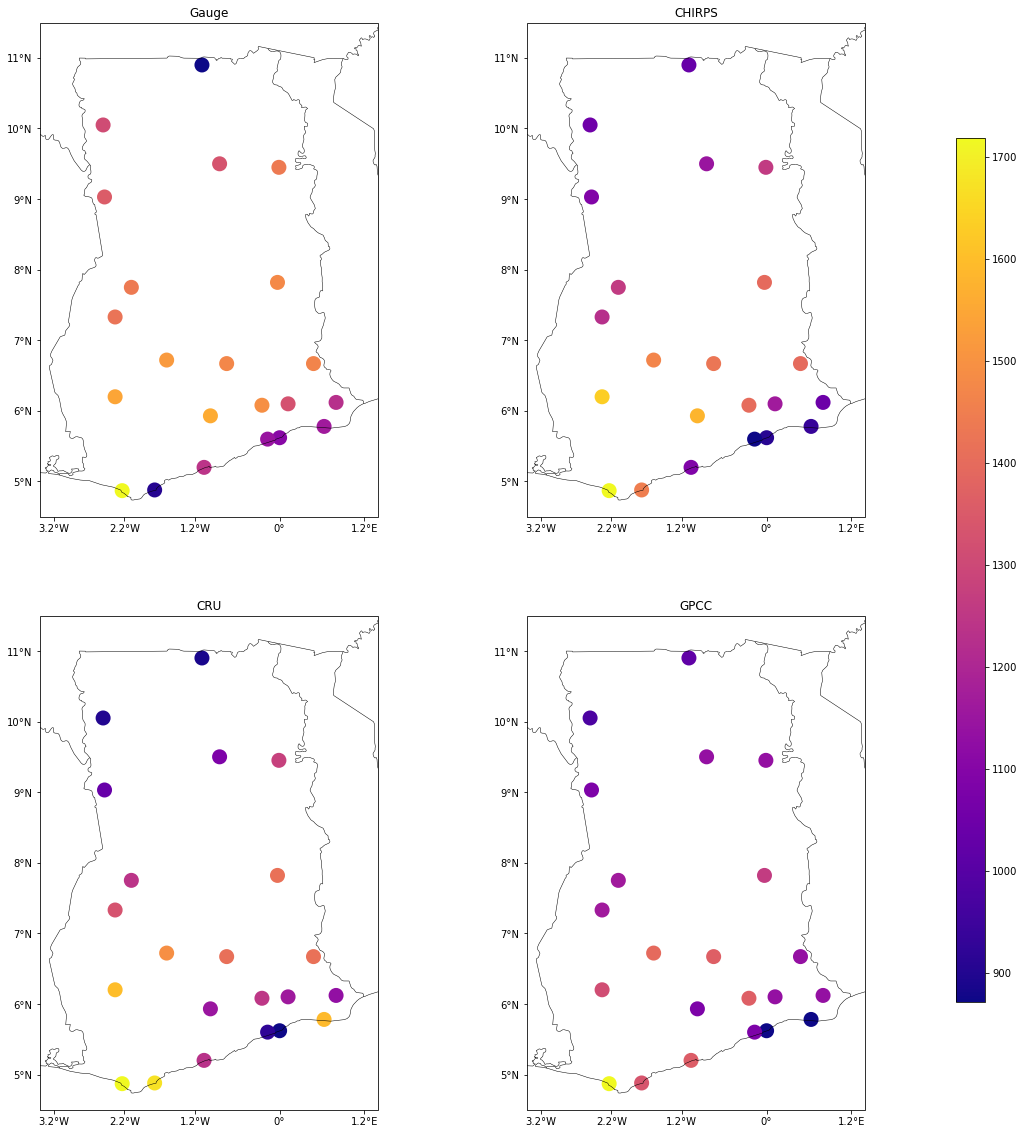

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16,20), subplot_kw = {'projection' : ccrs.PlateCarree()})
ax=axes.flatten()
for i in range(4):
    ax[i].add_feature(cf.COASTLINE.with_scale('10m'), linewidth=0.5)
    ax[i].add_feature(cf.BORDERS,linewidth=0.5)
    ax[i].set_extent([-3.4,1.4,11.5,4.5])
    ax[i].set_xticks([-3.2,-2.2,-1.2,0,1.2], crs=ccrs.PlateCarree())
    ax[i].set_yticks([11,10,9,8,7,6,5], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax[i].xaxis.set_major_formatter(lon_formatter)
    ax[i].yaxis.set_major_formatter(lat_formatter)
    ax[i].set_title(all_data.columns[2+i])

    
    cb = ax[i].scatter(x = all_data['Longitudes'], 
                       y = all_data['Latitudes'], 
                       c = all_data.iloc[:,2+i], 
                       cmap='plasma',
                       linewidths = 5,
                       s=100)

    color_bar = fig.add_axes([0.95, 0.2, 0.025, 0.6])
fig.colorbar(cb, cax=color_bar)
plt.savefig('Spatial pattern of annual rainfall.pdf')

In [16]:
all_data

,Longitudes,Latitudes,Gauge,CHIRPS,CRU,GPCC
Stations,,,,,,
Navrongo,-1.10,10.90,271.770000,958.548584,975.119995,1018.662476
Wa,-2.50,10.05,985.180857,973.933212,981.756897,979.361877
Tamale,-0.85,9.50,1025.347714,1063.264658,1067.857178,1134.706421
Yendi,-0.01,9.45,1198.891429,1169.524245,1156.934326,1134.706421
Bole,-2.48,9.03,1063.248571,1010.914816,1045.717163,1083.778320
Kete_Krachi,-0.03,7.82,1262.415429,1295.287515,1221.908569,1264.475464
Wenchi,-2.10,7.75,1195.640571,1169.818604,1139.662720,1165.104980
Sunyani,-2.33,7.33,1171.376857,1138.487322,1181.434204,1165.104980
Kumasi,-1.60,6.72,1328.718571,1362.241992,1256.540161,1396.328735


In [ ]:
# !conda install basemap

In [ ]:
# chirps.precip.groupby(chirps.precip.time.dt.season)
# chirps.precip.time.dt.month

In [ ]:
xr.open_dataset('GPCC/full_data_monthly_v2020_1981_1990_025.nc')

In [ ]:
numb = ['One', 'Two', 'Three']
name = ['Opp', 'Asa', 'Emma']

combine = {
    'numb': numb,
    'name': name
}

combine['fff'] = ['Seniro', 'Row', 'Col']
combine['another'] = ['wetrw','wefwe', 'wetew']

pd.DataFrame(data=combine)

In [ ]:

#     ssd = pd.DataFrame(cru_gh.values, columns = ['Gmet'])
    
#     chirps_to_ds = chirps_gh_try.to_dataset()
    
#     print(chirps_to_ds.coords['longitude'].values)
#     print(chirps_to_ds.coords['latitude'].values)
#     print(chirps_to_ds.data_vars)
    
#     for k, v in chirps_to_ds.data_vars.items():
#         lon = v['longitude'].values
#         lat = v['latitude'].values
#         precip = v.data
        
#         print(lon)
        
       


        
        
        
        
        
        
    
    
    
#     chirps_gh = chirps_gh.mean('time')
#     print(chirps_gh.to_dataframe().reset_index())


#     cru_gh = cru_data.sel(lon = long, lat = lati, method = 'nearest')
#     cru_gh = cru_gh.mean('time')
#     Gauge = Gauge.mean()
    
    
#     convert chirps and cru to dataframe
#     conv_chirps_gh = chirps_gh.to_dataframe()
#     conv_chirps_gh = pd.DataFrame([chirps_gh])

    
#     print(conv_chirps_gh)
#     conv_chirps_gh.to_dict()
    
    
    #convert cru to dataframe
#     conv_cru_gh = cru_gh.to_dataframe()
#     conv_cru_gh = pd.DataFrame([cru_gh])
    
#     print(conv_chirps_gh)
#     print(conv_cru_gh)
    ##select precip from chirps
#     precip_chirps = conv_chirps_gh['precip']
    
#     precip_gauge = pd.DataFrame(Gauge).set_index(precip_chirps.index)
#     T['longitude'] = long
#     T['latitude'] = lati
#     T['Gauge'] = Gauge
#     T['Cru data'] = 
#     T['Chirps data'] = precip_chirps
  
 #   conv_cru_gh['Stations'] = st
#     conv_cru_gh['Chirps_precip'] = precip_chirps
#     conv_cru_gh['Gauge_precip'] = precip_gauge
#     conv_cru_gh.rename(columns={'pre':'CRU_precip'}, inplace=True)
#     conv_cru_gh = pd.DataFrame(conv_cru_gh)
 #(conv_cru_gh, ignore_index=True)

# DATA = DATA.set_index('Stations')

#DATA = pd.DataFrame(DATA)

# DATA